In [82]:
import glob
import os
import numpy as np
import gzip
import torch
import pickle
import sys
import json
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

sys.path.append(os.path.abspath('..'))
from brush_stroke import BrushStroke

In [134]:
cache_dir = '../caches/vae_sharpie_final'
canvases_before_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_before_*.npy'))
canvases_after_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_after_*.npy'))
brush_strokes_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'stroke_parameters*.npy'))

# Ensure each of the files is in the order they were recorded in
canvases_before_fns = sorted(canvases_before_fns)
canvases_after_fns = sorted(canvases_after_fns)
brush_strokes_fns = sorted(brush_strokes_fns)

# canvases_before_fns = canvases_before_fns[:5]
# canvases_after_fns = canvases_after_fns[:5]
# brush_strokes_fns = brush_strokes_fns[:5]

# Load data
canvases_before = None
for canvases_before_fn in canvases_before_fns:
    with gzip.GzipFile(canvases_before_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_before = s if canvases_before is None else np.concatenate([canvases_before, s])

canvases_after = None
for canvases_after_fn in canvases_after_fns:
    with gzip.GzipFile(canvases_after_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_after = s if canvases_after is None else np.concatenate([canvases_after, s])

brush_strokes = []
for brush_strokes_fn in brush_strokes_fns:
    bs = pickle.load(open(brush_strokes_fn,'rb'))
    brush_strokes = bs if brush_strokes is None else np.concatenate([brush_strokes, bs]) 
for b in brush_strokes:
    b.vae_name = os.path.join('..', b.vae_name)

canvases_before = torch.from_numpy(canvases_before).float().nan_to_num()
canvases_after = torch.from_numpy(canvases_after).float().nan_to_num()
canvases_before = torch.mean(canvases_before, dim=3)
canvases_after = torch.mean(canvases_after, dim=3)

with open(os.path.join(cache_dir, 'stroke_library', 'stroke_settings_during_library.json'), 'r') as f:
    settings = json.load(f)
    CANVAS_WIDTH_M = settings['CANVAS_WIDTH_M']
    CANVAS_HEIGHT_M = settings['CANVAS_HEIGHT_M']

paths = []
starts = []
for b in brush_strokes:
    path = b.get_path()[:,:2]
    path = torch.flip(path, dims=(1,)) 
    path[:, 0] *= -1
    starts.append([b.yt, b.xt])
    paths.append(path.detach())
starts = torch.tensor(starts)
paths = torch.stack(paths, dim=0)

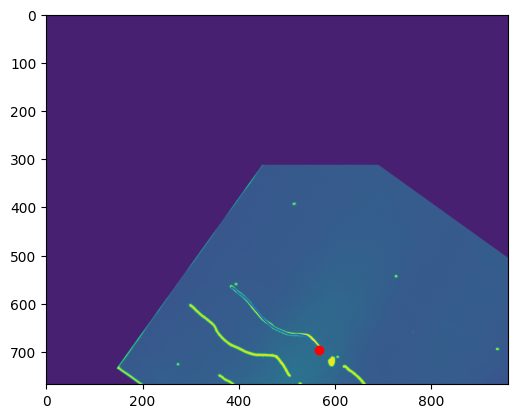

In [165]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

def random_shift_and_rotate(path, start, canvas_before, canvas_after):
    path = path.clone().numpy()
    start = start.clone().numpy()
    canvas_before = canvas_before.clone().numpy()
    canvas_after = canvas_after.clone().numpy()

    # Shift canvas to middle
    shift = 0.5 - start
    h, w = canvas_before.shape
    canvas_shift = np.array([shift[0] * h, shift[1] * w])
    canvas_shift = np.round(canvas_shift).astype(int)
    canvas_before = shift_image(canvas_before, canvas_shift[1], canvas_shift[0])
    canvas_after = shift_image(canvas_after, canvas_shift[1], canvas_shift[0])

    # Rotate everything
    theta = np.random.uniform(-np.pi, np.pi)
    mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    path = path @ mat.T
    path[:, 0] /= CANVAS_HEIGHT_M
    path[:, 1] /= CANVAS_WIDTH_M
    path += 0.5
    canvas_before = ndimage.rotate(canvas_before, np.rad2deg(theta), reshape=False)
    canvas_after = ndimage.rotate(canvas_after, np.rad2deg(theta), reshape=False)

    # Translate by random amount
    shift = np.random.uniform(-0.5, 0.5, size=2)
    path += shift
    canvas_shift = np.array([shift[0] * h, shift[1] * w])
    canvas_shift = np.round(canvas_shift).astype(int)
    canvas_before = shift_image(canvas_before, canvas_shift[1], canvas_shift[0])
    canvas_after = shift_image(canvas_after, canvas_shift[1], canvas_shift[0])

    return path, canvas_before, canvas_after

idx = 18
path, canvas_before, canvas_after = random_shift_and_rotate(paths[idx], starts[idx], canvases_before[idx], canvases_after[idx])
h, w = canvas_after.shape
path = np.flip(path, axis=1)
plt.plot(path[:, 0]*w, path[:, 1]*h)
# plot dot at path[0]
plt.plot(path[0, 0]*w, path[0, 1]*h, 'ro')
plt.imshow(canvas_after)